In [3]:
import torch as th
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import os
os.environ["DGLBACKEND"] = "pytorch"
import dgl
import dgl.function as fn
import dgl.nn as gnn
from tqdm import tqdm

import pandas as pd
import numpy as np
import joblib
import warnings
warnings.filterwarnings("ignore")
import faiss
from training_utils import *
from torch.utils.tensorboard import SummaryWriter
from random import shuffle
import faiss

# Preprocessing

In [19]:
g = joblib.load(filename='../data/graph/okved_graph_new_v2.pickle')
nfeat = g.ndata['feat'].float()
in_feats = nfeat.shape[1]
n_edges = g.num_edges()
# clf_graph = g
# g = dgl.edge_subgraph(graph=g, edges=(torch.logical_or(g.edata['type'] == 1, g.edata['type'] == 3)).nonzero().flatten())
okved_data = pd.read_csv('../data/okved2/okved_2014_w_sections.csv', index_col=0)
sections = okved_data['section_id'].values
num_negs = 1
neg_share = False
device = th.device('cpu')
num_hidden = 256
dropout = 0.25
lr = 3e-4
num_epochs = 1000
last_improvement = 0
require_improvements = 50

In [21]:
g

Graph(num_nodes=2637, num_edges=984278,
      ndata_schemes={'feat': Scheme(shape=(312,), dtype=torch.float64)}
      edata_schemes={'weight': Scheme(shape=(), dtype=torch.int64), 'type': Scheme(shape=(), dtype=torch.int64), 'train_mask': Scheme(shape=(), dtype=torch.bool), 'norm': Scheme(shape=(), dtype=torch.float32)})

In [17]:
g.edata['type'].unique(return_counts=True)

(tensor([0, 1, 2, 3]), tensor([370672,   6370, 550214,   1754]))

# Graph Attention Network

In [6]:
class GAT(nn.Module):
    def __init__(self, in_feats, n_hidden, n_classes, n_layers, activation, dropout):
        super().__init__()
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        self.n_classes = n_classes
        self.layers = nn.ModuleList()
        if n_layers > 1:
            self.layers.append(gnn.GATConv(in_feats, n_hidden, num_heads=4))
            for i in range(1, n_layers - 1):
                self.layers.append(gnn.GATConv(n_hidden, n_hidden, num_heads=4))
            self.layers.append(gnn.GATConv(n_hidden, n_classes, num_heads=4))
        else:
            self.layers.append(gnn.GATConv(in_feats, n_classes, num_heads=4))
        self.dropout = nn.Dropout(dropout)
        self.activation = activation

    def forward(self, g, x):
        h = x
        for l, layer in enumerate(self.layers):
            h = layer(g, h)
            if l != len(self.layers) - 1:
                h = self.activation(h)
                h = self.dropout(h)
        return h

In [7]:
num_layers = 3
best_state = None
writer_path = './runs/gat'
model_name = 'GAT'
model = GAT(in_feats, num_hidden, num_hidden, num_layers, F.relu, dropout)
model = model.to(device)
sampler = NegativeSampler(g, num_negs, neg_share, device)
criterion = CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
writer = SummaryWriter(writer_path)

In [5]:
train(model=model,
      sampler=sampler,
      graph=g,
      writer=writer,
      num_epochs=num_epochs,
      nfeat=nfeat,
      criterion=criterion,
      optimizer=optimizer,
      require_improvements=require_improvements)

No improvement found during the 50 last iterations, stopping optimization. on epoch = 545
Best loss = 0.48167353868484497
Best loss = 0.48167353868484497


  File "c:\Users\egrli\envs\okved_embeddings\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "C:\Users\egrli\AppData\Local\Programs\Python\Python310\lib\subprocess.py", line 501, in run
    with Popen(*popenargs, **kwargs) as process:
  File "C:\Users\egrli\AppData\Local\Programs\Python\Python310\lib\subprocess.py", line 966, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\egrli\AppData\Local\Programs\Python\Python310\lib\subprocess.py", line 1435, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,


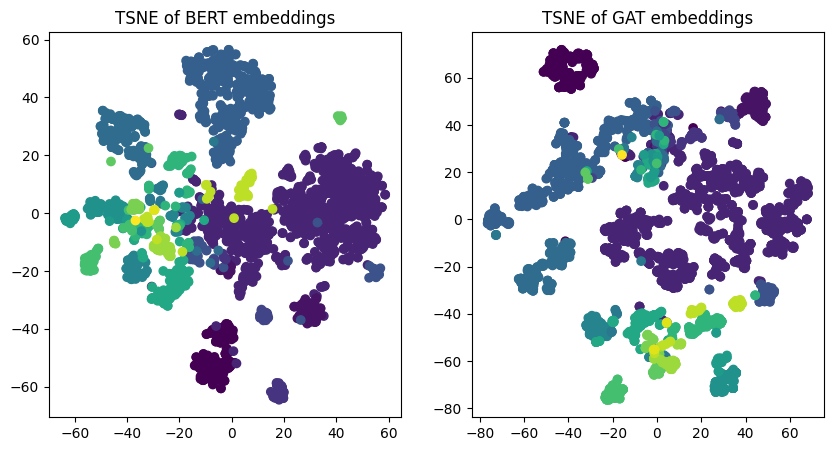

In [6]:
model.eval()
embeddings_model = model(g, nfeat).detach().mean(dim=[1, 2, 3]).numpy()[1:2637]
get_embs_and_plot(embeddings_model, g, nfeat, model_name, sections)

In [7]:
bert_scores, linear_regression_score_bert, svm_score_bert, model_scores, linear_regression_score_model, svm_score_model = eval_model(model_name)
joblib.dump(value=bert_scores, filename=f"../results/scores/scores_bert.pickle")
joblib.dump(value=model_scores, filename=f"../results/scores/scores_{model_name}.pickle")
print(f'Модель: {np.mean(model_scores):.2f}±{np.std(model_scores):.2f}')
print(f'Берт: {np.mean(bert_scores):.2f}±{np.std(bert_scores):.2f}')
print(f'SVR BERT: {svm_score_bert:.2f}')
print(f'SVR модель: {svm_score_model:.2f}')
print(f'Линейная регрессия BERT: {linear_regression_score_bert:.2f}')
print(f'Линейная регрессия модель {linear_regression_score_model:.2f}')

Модель: -0.35±0.63
Берт: -0.29±0.81
SVR BERT: -0.78
SVR модель: -0.63
Линейная регрессия BERT: 0.10
Линейная регрессия модель 0.12


In [8]:
embeddings_model = np.load(file=f"../results/embs/{model_name}.npy")
embeddings_model_2d = np.load(file=f"../results/embs/{model_name}_2d.npy")

dim = embeddings_model.shape[1]
index = faiss.IndexFlatL2(dim)
index.add(embeddings_model)

In [9]:
topn = 7
with open('results.txt', 'w', encoding='utf8') as fp:
    order = list(range(len(okved_data)))
    shuffle(order)
    for idx in tqdm(order):
        # print(idx)
        D, I = index.search(embeddings_model[[idx]], topn)
        data = okved_data['native_code'] + ' ' + okved_data['name_okved']
        closest = data.iloc[I[0]].tolist()
        closest_s = '\n'.join(closest)
        fp.write(f"{idx}\n{closest_s}\n\n")

100%|██████████| 2636/2636 [00:01<00:00, 1890.39it/s]


In [10]:
names = (okved_data['native_code'] + ': ' + okved_data['name_okved']).apply(cut, ln=50)
colors = okved_data['section_id'].values

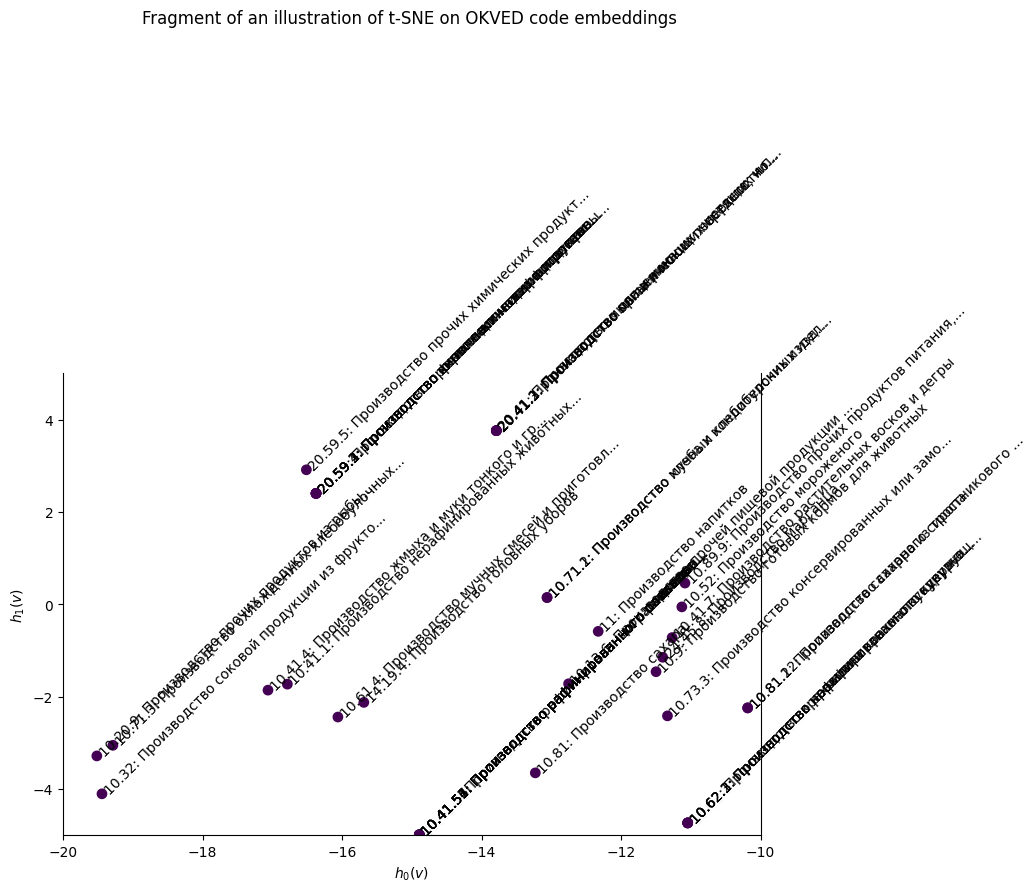

In [11]:
okved_data[okved_data['native_code']=='46.72.21'].index[0]-1
names = (okved_data['native_code'] + ': ' + okved_data['name_okved']).apply(cut, ln=50)
colors = okved_data['section_id'].values
draw_2d(embeddings_model_2d, names, colors, 
        xlim=(-20, -10), ylim=(-5, 5), 
        figsize=(9, 6), annotate=True,
        node_size=45,
        hide_spins=('top', ))

# Chebyshev Conv

In [12]:
class ChConv(nn.Module):
    def __init__(self, in_feats, n_hidden, n_classes, n_layers, activation, dropout):
        super().__init__()
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        self.n_classes = n_classes
        self.layers = nn.ModuleList()
        if n_layers > 1:
            self.layers.append(gnn.ChebConv(in_feats, n_hidden, k=2))
            for i in range(1, n_layers - 1):
                self.layers.append(gnn.ChebConv(n_hidden, n_hidden, k=2))
            self.layers.append(gnn.ChebConv(n_hidden, n_classes, k=2))
        else:
            self.layers.append(gnn.ChebConv(in_feats, n_classes, k=2))
        self.dropout = nn.Dropout(dropout)
        self.activation = activation

    def forward(self, g, x):
        h = x
        for l, layer in enumerate(self.layers):
            h = layer(g, h)
            if l != len(self.layers) - 1:
                h = self.activation(h)
                h = self.dropout(h)
        return h

In [13]:
best_state = None
num_layers = 3
writer_path = './runs/cheb'
model_name = 'Cheb'
model = ChConv(in_feats, num_hidden, num_hidden, num_layers, F.relu, dropout)
model = model.to(device)
sampler = NegativeSampler(g, num_negs, neg_share, device)
criterion = CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
writer = SummaryWriter(writer_path)

In [14]:
train(model=model,
      sampler=sampler,
      graph=g,
      writer=writer,
      num_epochs=num_epochs,
      nfeat=nfeat,
      criterion=criterion,
      optimizer=optimizer,
      require_improvements=require_improvements)

No improvement found during the 50 last iterations, stopping optimization. on epoch = 746
Best loss = 0.478992760181427
Best loss = 0.478992760181427


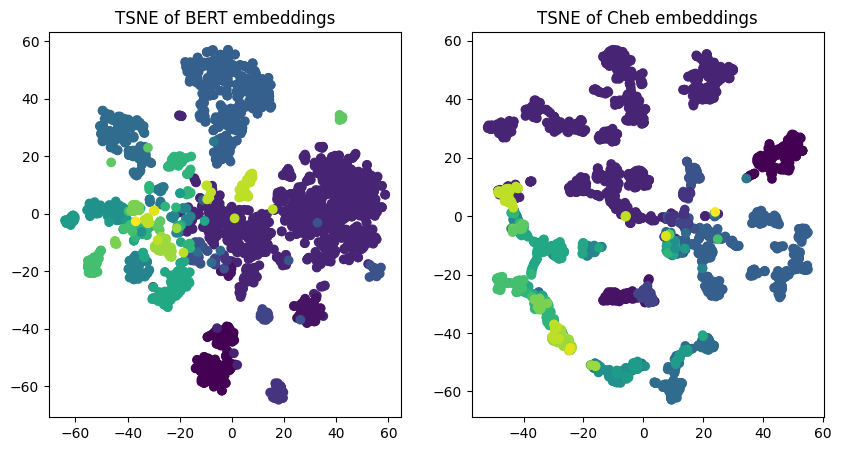

In [15]:
model.eval()
embeddings_model = model(g, nfeat).detach().numpy()[1:2637]
get_embs_and_plot(embeddings_model, g, nfeat, model_name, sections)

In [16]:
bert_scores, linear_regression_score_bert, svm_score_bert, model_scores, linear_regression_score_model, svm_score_model = eval_model(model_name)
joblib.dump(value=model_scores, filename=f"../results/scores/scores_{model_name}.pickle")
print(f'Модель: {np.mean(model_scores):.2f}±{np.std(model_scores):.2f}')
print(f'Берт: {np.mean(bert_scores):.2f}±{np.std(bert_scores):.2f}')
print(f'SVR BERT: {svm_score_bert:.2f}')
print(f'SVR модель: {svm_score_model:.2f}')
print(f'Линейная регрессия BERT: {linear_regression_score_bert:.2f}')
print(f'Линейная регрессия модель {linear_regression_score_model:.2f}')

Модель: -0.84±1.26
Берт: -0.30±0.94
SVR BERT: -0.78
SVR модель: -1.12
Линейная регрессия BERT: 0.10
Линейная регрессия модель -0.03


In [17]:
embeddings_model = np.load(file=f"../results/embs/{model_name}.npy")
embeddings_model_2d = np.load(file=f"../results/embs/{model_name}_2d.npy")

dim = embeddings_model.shape[1]
index = faiss.IndexFlatL2(dim)
index.add(embeddings_model)

In [18]:
topn = 7
with open('results.txt', 'w', encoding='utf8') as fp:
    order = list(range(len(okved_data)))
    shuffle(order)
    for idx in tqdm(order):
        # print(idx)
        D, I = index.search(embeddings_model[[idx]], topn)
        data = okved_data['native_code'] + ' ' + okved_data['name_okved']
        closest = data.iloc[I[0]].tolist()
        closest_s = '\n'.join(closest)
        fp.write(f"{idx}\n{closest_s}\n\n")

100%|██████████| 2636/2636 [00:01<00:00, 1864.53it/s]


In [19]:
names = (okved_data['native_code'] + ': ' + okved_data['name_okved']).apply(cut, ln=50)
colors = okved_data['section_id'].values

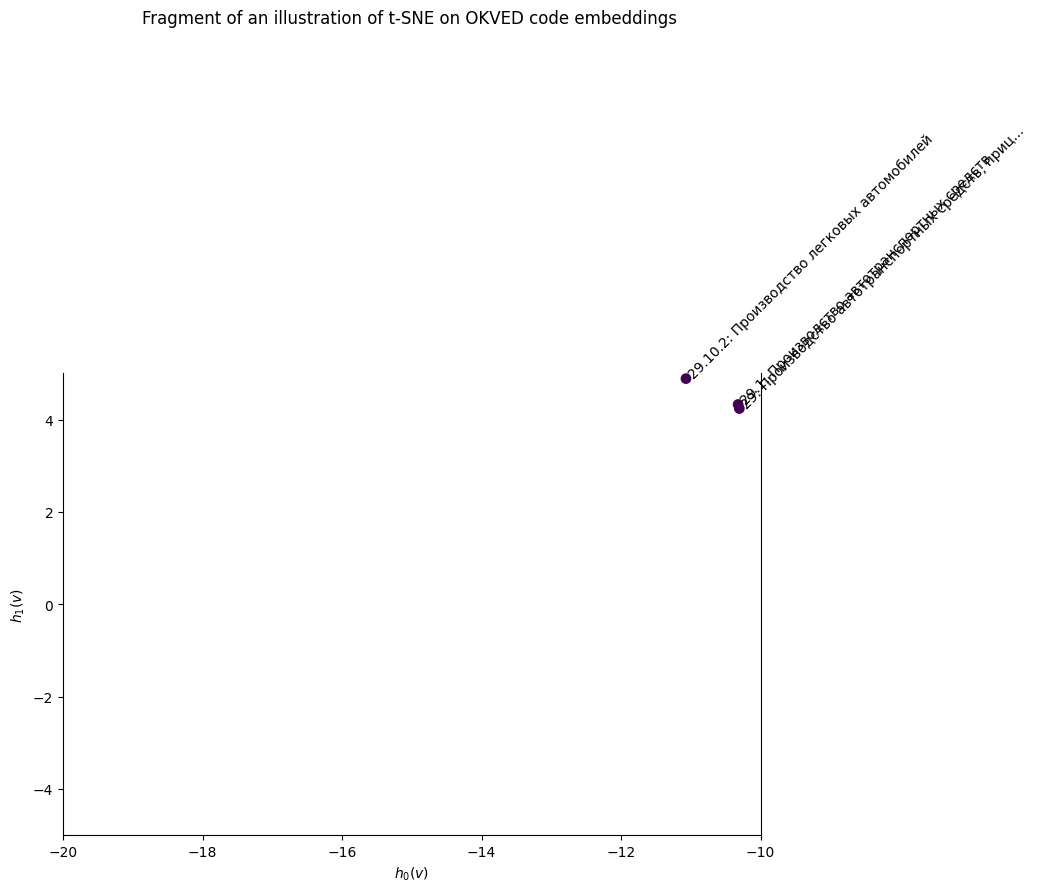

In [20]:
okved_data[okved_data['native_code']=='46.72.21'].index[0]-1
names = (okved_data['native_code'] + ': ' + okved_data['name_okved']).apply(cut, ln=50)
colors = okved_data['section_id'].values
draw_2d(embeddings_model_2d, names, colors, 
        xlim=(-20, -10), ylim=(-5, 5), 
        figsize=(9, 6), annotate=True,
        node_size=45,
        hide_spins=('top', ))

# SAGE

In [21]:
class Sage(nn.Module):
    def __init__(self, in_feats, n_hidden, n_classes, n_layers, activation, dropout):
        super().__init__()
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        self.n_classes = n_classes
        self.layers = nn.ModuleList()
        if n_layers > 1:
            self.layers.append(gnn.SAGEConv(in_feats, n_hidden, aggregator_type='lstm'))
            for i in range(1, n_layers - 1):
                self.layers.append(gnn.SAGEConv(n_hidden, n_hidden, aggregator_type='lstm'))
            self.layers.append(gnn.SAGEConv(n_hidden, n_classes, aggregator_type='lstm'))
        else:
            self.layers.append(gnn.SAGEConv(in_feats, n_classes, aggregator_type='lstm'))
        self.dropout = nn.Dropout(dropout)
        self.activation = activation

    def forward(self, g, x):
        h = x
        for l, layer in enumerate(self.layers):
            h = layer(g, h)
            if l != len(self.layers) - 1:
                h = self.activation(h)
                h = self.dropout(h)
        return h

In [22]:
best_state = None
num_layers = 4
writer_path = './runs/sage'
model_name = 'Sage'
model = Sage(in_feats, num_hidden, num_hidden, num_layers, F.relu, dropout)
model = model.to(device)
sampler = NegativeSampler(g, num_negs, neg_share, device)
criterion = CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
writer = SummaryWriter(writer_path)

In [23]:
train(model=model,
      sampler=sampler,
      graph=g,
      writer=writer,
      num_epochs=num_epochs,
      nfeat=nfeat,
      criterion=criterion,
      optimizer=optimizer,
      require_improvements=require_improvements)

No improvement found during the 50 last iterations, stopping optimization. on epoch = 784
Best loss = 0.4384506940841675
Best loss = 0.4384506940841675


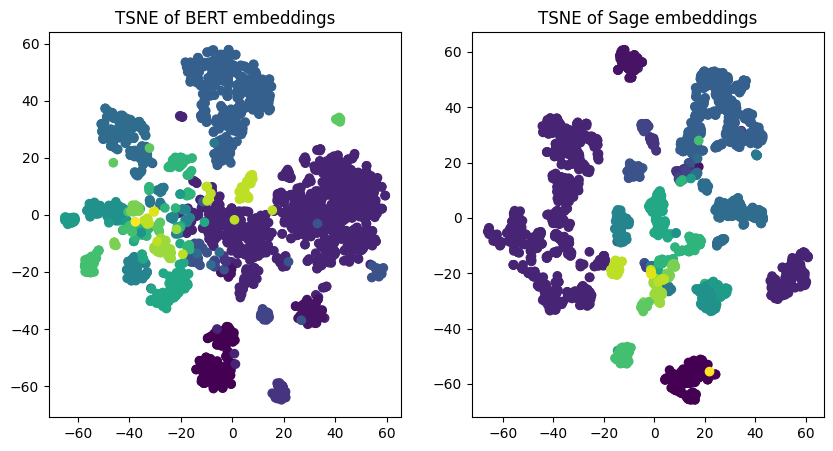

In [24]:
model.eval()
embeddings_model = model(g, nfeat).detach().numpy()[1:2637]
get_embs_and_plot(embeddings_model, g, nfeat, model_name, sections)

In [25]:
bert_scores, linear_regression_score_bert, svm_score_bert, model_scores, linear_regression_score_model, svm_score_model = eval_model(model_name)
joblib.dump(value=model_scores, filename=f"../results/scores/scores_{model_name}.pickle")
print(f'Модель: {np.mean(model_scores):.2f}±{np.std(model_scores):.2f}')
print(f'Берт: {np.mean(bert_scores):.2f}±{np.std(bert_scores):.2f}')
print(f'SVR BERT: {svm_score_bert:.2f}')
print(f'SVR модель: {svm_score_model:.2f}')
print(f'Линейная регрессия BERT: {linear_regression_score_bert:.2f}')
print(f'Линейная регрессия модель {linear_regression_score_model:.2f}')

Модель: 0.08±0.41
Берт: -0.41±1.05
SVR BERT: -0.78
SVR модель: -0.45
Линейная регрессия BERT: 0.10
Линейная регрессия модель 0.06


In [26]:
embeddings_model = np.load(file=f"../results/embs/{model_name}.npy")
embeddings_model_2d = np.load(file=f"../results/embs/{model_name}_2d.npy")

dim = embeddings_model.shape[1]
index = faiss.IndexFlatL2(dim)
index.add(embeddings_model)

In [27]:
topn = 7
with open('results.txt', 'w', encoding='utf8') as fp:
    order = list(range(len(okved_data)))
    shuffle(order)
    for idx in tqdm(order):
        # print(idx)
        D, I = index.search(embeddings_model[[idx]], topn)
        data = okved_data['native_code'] + ' ' + okved_data['name_okved']
        closest = data.iloc[I[0]].tolist()
        closest_s = '\n'.join(closest)
        fp.write(f"{idx}\n{closest_s}\n\n")

100%|██████████| 2636/2636 [00:01<00:00, 1784.08it/s]


In [28]:
names = (okved_data['native_code'] + ': ' + okved_data['name_okved']).apply(cut, ln=50)
colors = okved_data['section_id'].values

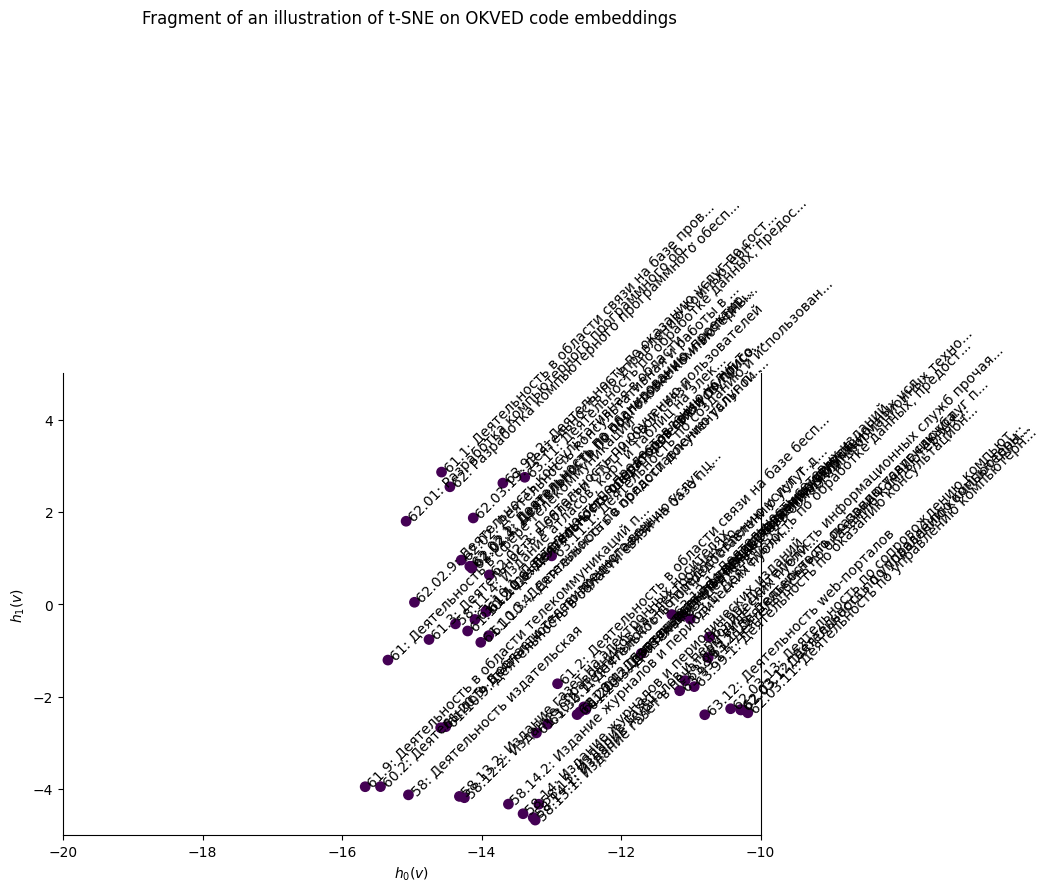

In [29]:
okved_data[okved_data['native_code']=='46.72.21'].index[0]-1
names = (okved_data['native_code'] + ': ' + okved_data['name_okved']).apply(cut, ln=50)
colors = okved_data['section_id'].values
draw_2d(embeddings_model_2d, names, colors, 
        xlim=(-20, -10), ylim=(-5, 5), 
        figsize=(9, 6), annotate=True,
        node_size=45,
        hide_spins=('top', ))

# DotGatConv

In [30]:
class DotGat(nn.Module):
    def __init__(self, in_feats, n_hidden, n_classes, n_layers, activation, dropout):
        super().__init__()
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        self.n_classes = n_classes
        self.layers = nn.ModuleList()
        if n_layers > 1:
            self.layers.append(gnn.DotGatConv(in_feats, n_hidden, num_heads=4))
            for i in range(1, n_layers - 1):
                self.layers.append(gnn.DotGatConv(n_hidden, n_hidden, num_heads=4))
            self.layers.append(gnn.DotGatConv(n_hidden, n_classes, num_heads=4))
        else:
            self.layers.append(gnn.DotGatConv(in_feats, n_classes, num_heads=4))
        self.dropout = nn.Dropout(dropout)
        self.activation = activation

    def forward(self, g, x):
        h = x
        for l, layer in enumerate(self.layers):
            h = layer(g, h)
            if l != len(self.layers) - 1:
                h = self.activation(h)
                h = self.dropout(h)
        return h

In [31]:
best_state = None
num_layers = 1
writer_path = './runs/dotgat'
model_name = 'DotGat'
model = DotGat(in_feats, num_hidden, num_hidden, num_layers, F.relu, dropout)
model = model.to(device)
sampler = NegativeSampler(g, num_negs, neg_share, device)
criterion = CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
writer = SummaryWriter(writer_path)

In [32]:
train(model=model,
      sampler=sampler,
      graph=g,
      writer=writer,
      num_epochs=num_epochs,
      nfeat=nfeat,
      criterion=criterion,
      optimizer=optimizer,
      require_improvements=require_improvements)

No improvement found during the 50 last iterations, stopping optimization. on epoch = 400
Best loss = 0.5096017718315125
Best loss = 0.5096017718315125


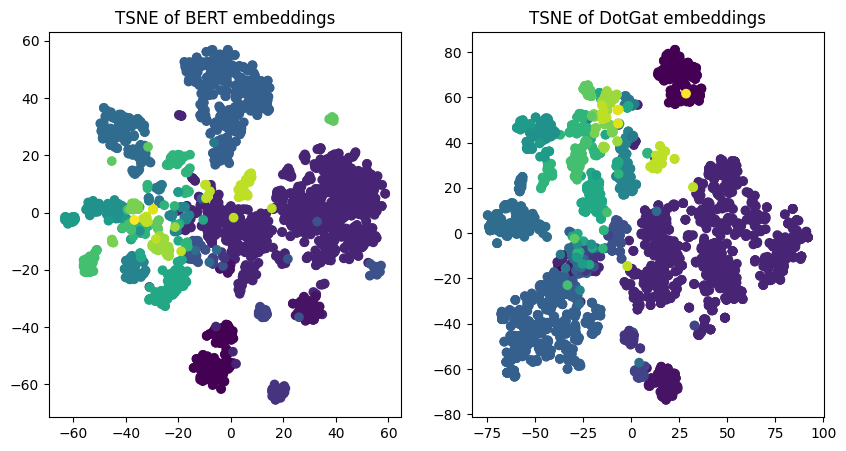

In [33]:
model.eval()
embeddings_model = model(g, nfeat).detach().mean(dim=1).numpy()[1:2637]
get_embs_and_plot(embeddings_model, g, nfeat, model_name, sections)

In [34]:
bert_scores, linear_regression_score_bert, svm_score_bert, model_scores, linear_regression_score_model, svm_score_model = eval_model(model_name)
joblib.dump(value=bert_scores, filename=f"../results/scores/scores_bert.pickle")
joblib.dump(value=model_scores, filename=f"../results/scores/scores_{model_name}.pickle")
print(f'Модель: {np.mean(model_scores):.2f}±{np.std(model_scores):.2f}')
print(f'Берт: {np.mean(bert_scores):.2f}±{np.std(bert_scores):.2f}')
print(f'SVR BERT: {svm_score_bert:.2f}')
print(f'SVR модель: {svm_score_model:.2f}')
print(f'Линейная регрессия BERT: {linear_regression_score_bert:.2f}')
print(f'Линейная регрессия модель {linear_regression_score_model:.2f}')

Модель: -0.32±0.42
Берт: -0.36±1.02
SVR BERT: -0.78
SVR модель: -0.44
Линейная регрессия BERT: 0.10
Линейная регрессия модель 0.11


In [35]:
embeddings_model = np.load(file=f"../results/embs/{model_name}.npy")
embeddings_model_2d = np.load(file=f"../results/embs/{model_name}_2d.npy")

dim = embeddings_model.shape[1]
index = faiss.IndexFlatL2(dim)
index.add(embeddings_model)

In [36]:
topn = 7
with open('results.txt', 'w', encoding='utf8') as fp:
    order = list(range(len(okved_data)))
    shuffle(order)
    for idx in tqdm(order):
        # print(idx)
        D, I = index.search(embeddings_model[[idx]], topn)
        data = okved_data['native_code'] + ' ' + okved_data['name_okved']
        closest = data.iloc[I[0]].tolist()
        closest_s = '\n'.join(closest)
        fp.write(f"{idx}\n{closest_s}\n\n")

100%|██████████| 2636/2636 [00:01<00:00, 1845.49it/s]


In [37]:
names = (okved_data['native_code'] + ': ' + okved_data['name_okved']).apply(cut, ln=50)
colors = okved_data['section_id'].values

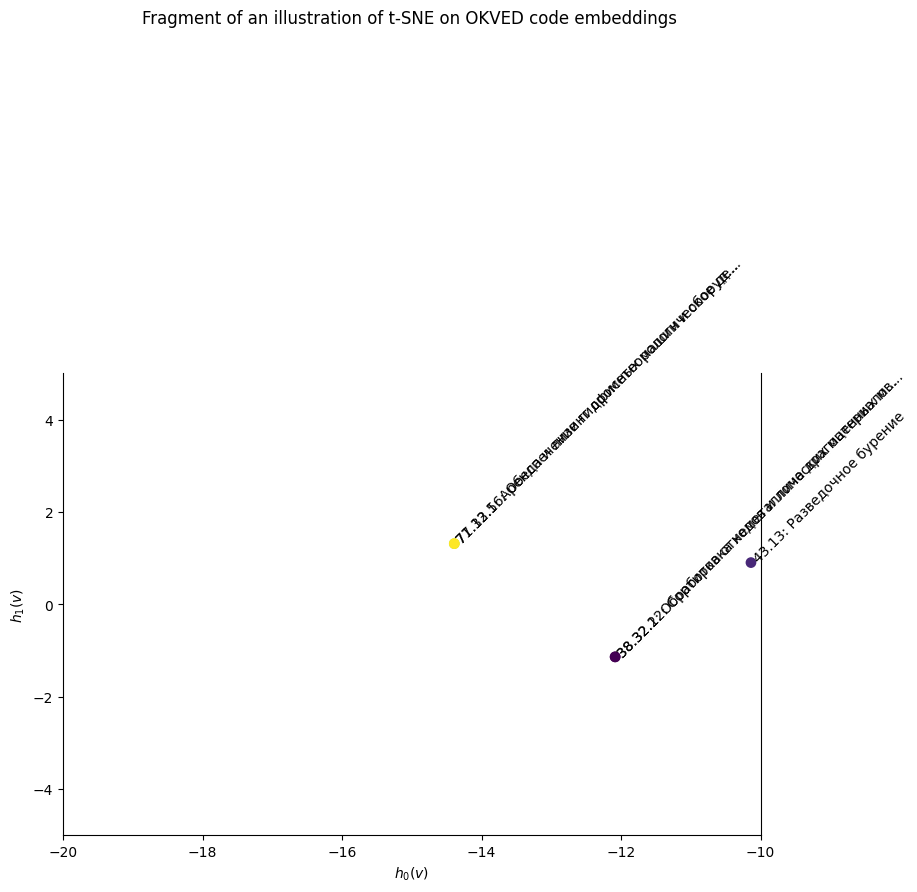

In [38]:
okved_data[okved_data['native_code']=='46.72.21'].index[0]-1
names = (okved_data['native_code'] + ': ' + okved_data['name_okved']).apply(cut, ln=50)
colors = okved_data['section_id'].values
draw_2d(embeddings_model_2d, names, colors, 
        xlim=(-20, -10), ylim=(-5, 5), 
        figsize=(9, 6), annotate=True,
        node_size=45,
        hide_spins=('top', ))

# PNAConv

In [39]:
class PNAConv(nn.Module):
    def __init__(self, in_feats, n_hidden, n_classes, n_layers, activation, dropout):
        super().__init__()
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        self.n_classes = n_classes
        self.layers = nn.ModuleList()
        if n_layers > 1:
            self.layers.append(gnn.PNAConv(in_feats, n_hidden, ['mean', 'max', 'sum'], ['amplification'], 2.5))
            for i in range(1, n_layers - 1):
                self.layers.append(gnn.PNAConv(n_hidden, n_hidden, ['mean', 'max', 'sum'], ['amplification'], 2.5))
            self.layers.append(gnn.PNAConv(n_hidden, n_classes, ['mean', 'max', 'sum'], ['amplification'], 2.5))
        else:
            self.layers.append(gnn.PNAConv(in_feats, n_classes, ['mean', 'max', 'sum'], ['amplification'], 2.5))
        self.dropout = nn.Dropout(dropout)
        self.activation = activation

    def forward(self, g, x):
        h = x
        for l, layer in enumerate(self.layers):
            h = layer(g, h)
            if l != len(self.layers) - 1:
                h = self.activation(h)
                h = self.dropout(h)
        return h

In [40]:
best_state = None
num_layers = 2
writer_path = './runs/PNAConv'
model_name = 'PNAConv'
model = PNAConv(in_feats, num_hidden, num_hidden, num_layers, F.relu, dropout)
model = model.to(device)
sampler = NegativeSampler(g, num_negs, neg_share, device)
criterion = CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
writer = SummaryWriter(writer_path)

In [41]:
train(model=model,
      sampler=sampler,
      graph=g,
      writer=writer,
      num_epochs=num_epochs,
      nfeat=nfeat,
      criterion=criterion,
      optimizer=optimizer,
      require_improvements=require_improvements)

No improvement found during the 50 last iterations, stopping optimization. on epoch = 600
Best loss = 0.5277281403541565
Best loss = 0.5277281403541565


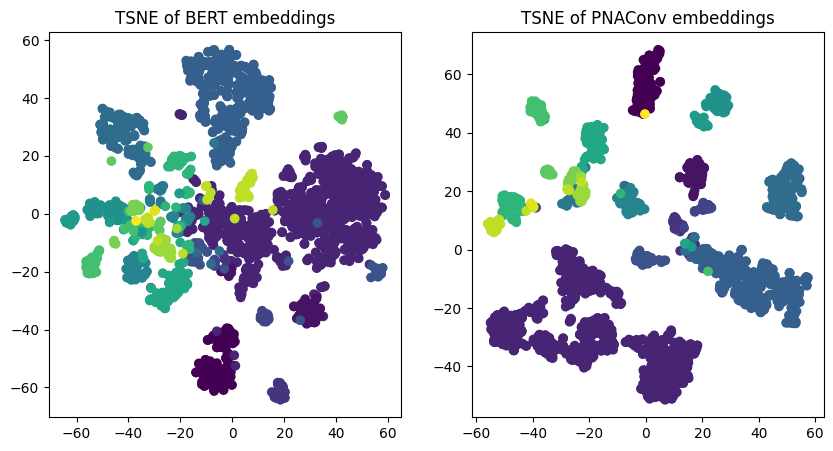

In [42]:
model.eval()
embeddings_model = model(g, nfeat).detach().numpy()[1:2637]
get_embs_and_plot(embeddings_model, g, nfeat, model_name, sections)

In [43]:
bert_scores, linear_regression_score_bert, svm_score_bert, model_scores, linear_regression_score_model, svm_score_model = eval_model(model_name)
joblib.dump(value=model_scores, filename=f"../results/scores/scores_{model_name}.pickle")
print(f'Модель: {np.mean(model_scores):.2f}±{np.std(model_scores):.2f}')
print(f'Берт: {np.mean(bert_scores):.2f}±{np.std(bert_scores):.2f}')
print(f'SVR BERT: {svm_score_bert:.2f}')
print(f'SVR модель: {svm_score_model:.2f}')
print(f'Линейная регрессия BERT: {linear_regression_score_bert:.2f}')
print(f'Линейная регрессия модель {linear_regression_score_model:.2f}')

Модель: -0.19±0.75
Берт: -0.41±0.79
SVR BERT: -0.78
SVR модель: -0.61
Линейная регрессия BERT: 0.10
Линейная регрессия модель 0.11


In [44]:
embeddings_model = np.load(file=f"../results/embs/{model_name}.npy")
embeddings_model_2d = np.load(file=f"../results/embs/{model_name}_2d.npy")

dim = embeddings_model.shape[1]
index = faiss.IndexFlatL2(dim)
index.add(embeddings_model)

In [45]:
topn = 7
with open('results.txt', 'w', encoding='utf8') as fp:
    order = list(range(len(okved_data)))
    shuffle(order)
    for idx in tqdm(order):
        # print(idx)
        D, I = index.search(embeddings_model[[idx]], topn)
        data = okved_data['native_code'] + ' ' + okved_data['name_okved']
        closest = data.iloc[I[0]].tolist()
        closest_s = '\n'.join(closest)
        fp.write(f"{idx}\n{closest_s}\n\n")

100%|██████████| 2636/2636 [00:01<00:00, 1857.04it/s]


In [46]:
names = (okved_data['native_code'] + ': ' + okved_data['name_okved']).apply(cut, ln=50)
colors = okved_data['section_id'].values

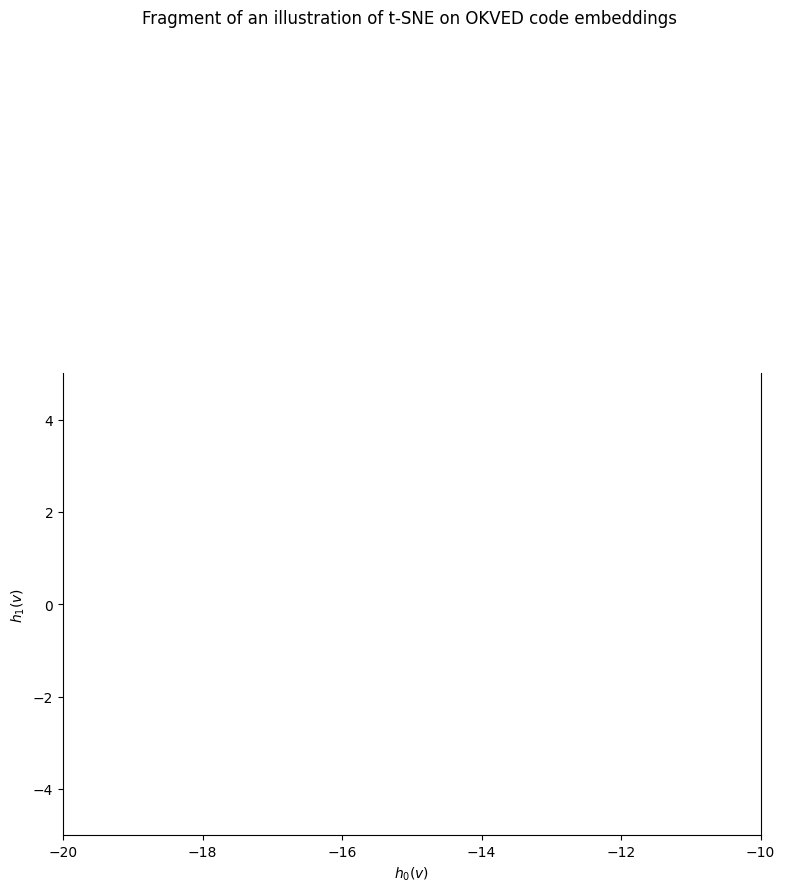

In [47]:
okved_data[okved_data['native_code']=='46.72.21'].index[0]-1
names = (okved_data['native_code'] + ': ' + okved_data['name_okved']).apply(cut, ln=50)
colors = okved_data['section_id'].values
draw_2d(embeddings_model_2d, names, colors, 
        xlim=(-20, -10), ylim=(-5, 5), 
        figsize=(9, 6), annotate=True,
        node_size=45,
        hide_spins=('top', ))

# GCN2Conv

In [48]:
class GCN2Conv(nn.Module):
    def __init__(self, in_feats, n_hidden, n_classes, n_layers, activation, dropout):
        super().__init__()
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        self.n_classes = n_classes
        self.layers = nn.ModuleList()
        if n_layers > 1:
            self.layers.append(gnn.GCN2Conv(in_feats, layer=1))
            for i in range(1, n_layers - 1):
                self.layers.append(gnn.GCN2Conv(in_feats, layer=i+1))
            self.layers.append(gnn.GCN2Conv(in_feats, layer=n_layers))
        else:
            self.layers.append(gnn.GCN2Conv(in_feats, layer=0))
        self.dropout = nn.Dropout(dropout)
        self.activation = activation

    def forward(self, g, x):
        h = x
        for l, layer in enumerate(self.layers):
            h = layer(g, h, h)
            if l != len(self.layers) - 1:
                h = self.activation(h)
                h = self.dropout(h)
        return h

In [49]:
best_state = None
num_layers = 2
writer_path = './runs/GCN2Conv_v2'
model_name = 'GCN2Conv_v2'
model = GCN2Conv(in_feats, num_hidden, num_hidden, num_layers, F.relu, dropout)
model = model.to(device)
sampler = NegativeSampler(g, num_negs, neg_share, device)
criterion = CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
writer = SummaryWriter(writer_path)

In [50]:
train(model=model,
      sampler=sampler,
      graph=g,
      writer=writer,
      num_epochs=num_epochs,
      nfeat=nfeat,
      criterion=criterion,
      optimizer=optimizer,
      require_improvements=require_improvements)

No improvement found during the 50 last iterations, stopping optimization. on epoch = 690
Best loss = 26.503427505493164
Best loss = 26.503427505493164


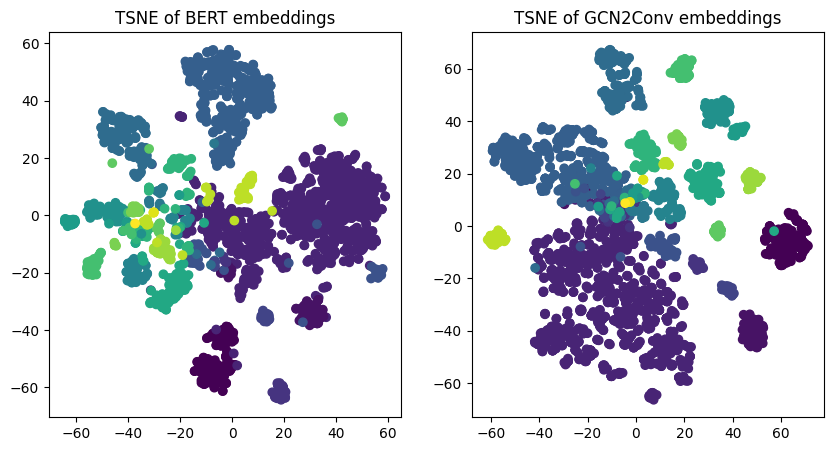

In [51]:
model.eval()
embeddings_model = model(g, nfeat).detach().numpy()[1:2637]
get_embs_and_plot(embeddings_model, g, nfeat, model_name, sections)

In [52]:
bert_scores, linear_regression_score_bert, svm_score_bert, model_scores, linear_regression_score_model, svm_score_model = eval_model(model_name)
joblib.dump(value=model_scores, filename=f"../results/scores/scores_{model_name}.pickle")
print(f'Модель: {np.mean(model_scores):.2f}±{np.std(model_scores):.2f}')
print(f'Берт: {np.mean(bert_scores):.2f}±{np.std(bert_scores):.2f}')
print(f'SVR BERT: {svm_score_bert:.2f}')
print(f'SVR модель: {svm_score_model:.2f}')
print(f'Линейная регрессия BERT: {linear_regression_score_bert:.2f}')
print(f'Линейная регрессия модель {linear_regression_score_model:.2f}')

Модель: 0.01±0.43
Берт: -0.39±0.93
SVR BERT: -0.78
SVR модель: -0.67
Линейная регрессия BERT: 0.10
Линейная регрессия модель 0.11


In [53]:
embeddings_model = np.load(file=f"../results/embs/{model_name}.npy")
embeddings_model_2d = np.load(file=f"../results/embs/{model_name}_2d.npy")

dim = embeddings_model.shape[1]
index = faiss.IndexFlatL2(dim)
index.add(embeddings_model)

In [54]:
topn = 7
with open('results.txt', 'w', encoding='utf8') as fp:
    order = list(range(len(okved_data)))
    shuffle(order)
    for idx in tqdm(order):
        # print(idx)
        D, I = index.search(embeddings_model[[idx]], topn)
        data = okved_data['native_code'] + ' ' + okved_data['name_okved']
        closest = data.iloc[I[0]].tolist()
        closest_s = '\n'.join(closest)
        fp.write(f"{idx}\n{closest_s}\n\n")

100%|██████████| 2636/2636 [00:01<00:00, 1698.56it/s]


In [55]:
names = (okved_data['native_code'] + ': ' + okved_data['name_okved']).apply(cut, ln=50)
colors = okved_data['section_id'].values

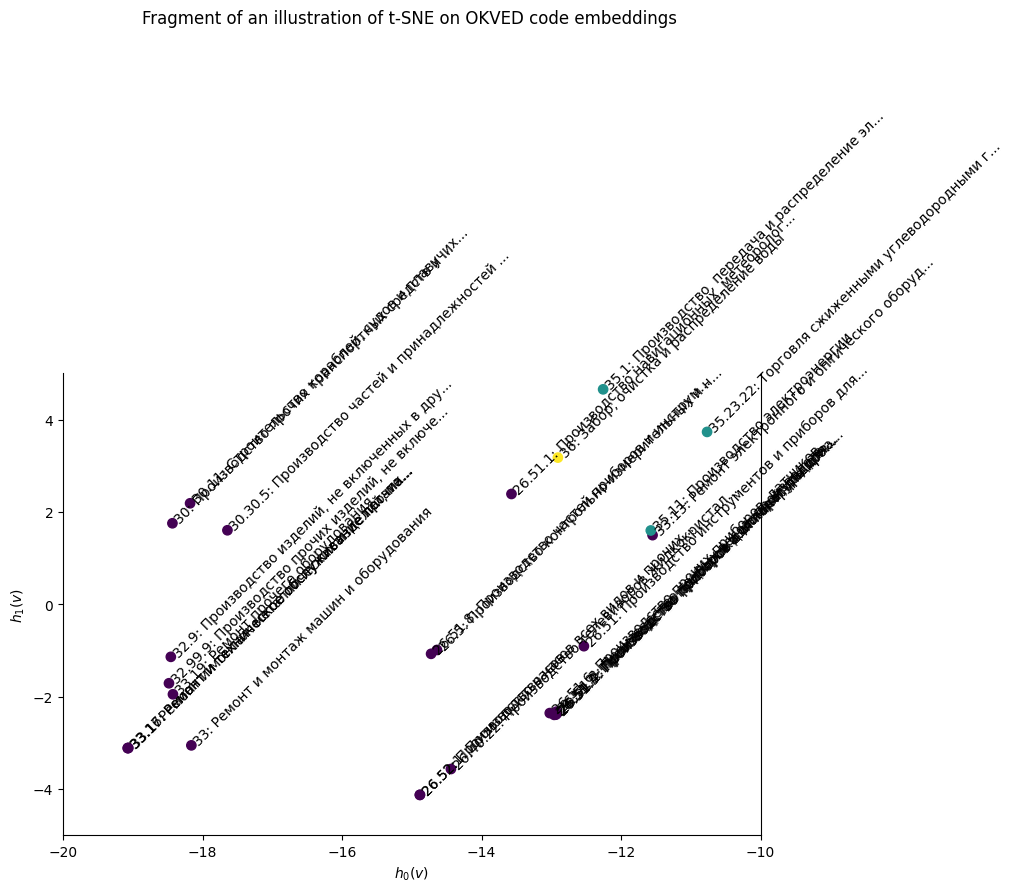

In [56]:
okved_data[okved_data['native_code']=='46.72.21'].index[0]-1
names = (okved_data['native_code'] + ': ' + okved_data['name_okved']).apply(cut, ln=50)
colors = okved_data['section_id'].values
draw_2d(embeddings_model_2d, names, colors, 
        xlim=(-20, -10), ylim=(-5, 5), 
        figsize=(9, 6), annotate=True,
        node_size=45,
        hide_spins=('top', ))

# GatV2

In [76]:
class GATv2Conv(nn.Module):
    def __init__(self, in_feats, n_hidden, n_classes, n_layers, activation, dropout):
        super().__init__()
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        self.n_classes = n_classes
        self.layers = nn.ModuleList()
        if n_layers > 1:
            self.layers.append(gnn.GATv2Conv(in_feats, n_hidden, num_heads=4))
            for i in range(1, n_layers - 1):
                self.layers.append(gnn.GATv2Conv(n_hidden, n_hidden, num_heads=4))
            self.layers.append(gnn.GATv2Conv(n_hidden, n_classes, num_heads=4))
        else:
            self.layers.append(gnn.GATv2Conv(in_feats, n_classes, num_heads=4))
        self.dropout = nn.Dropout(dropout)
        self.activation = activation

    def forward(self, g, x):
        h = x
        for l, layer in enumerate(self.layers):
            h = layer(g, h).mean(dim=1)
            if l != len(self.layers) - 1:
                h = self.activation(h)
                h = self.dropout(h)
        return h

In [80]:
num_layers = 2
best_state = None
writer_path = './runs/gatv2'
model_name = 'GAT_v2'
model = GATv2Conv(in_feats, num_hidden, num_hidden, num_layers, F.relu, dropout)
model = model.to(device)
sampler = NegativeSampler(g, num_negs, neg_share, device)
criterion = CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
writer = SummaryWriter(writer_path)

In [81]:
train(model=model,
      sampler=sampler,
      graph=g,
      writer=writer,
      num_epochs=num_epochs,
      nfeat=nfeat,
      criterion=criterion,
      optimizer=optimizer,
      require_improvements=require_improvements)

No improvement found during the 50 last iterations, stopping optimization. on epoch = 594
Best loss = 0.4820365607738495
Best loss = 0.4820365607738495


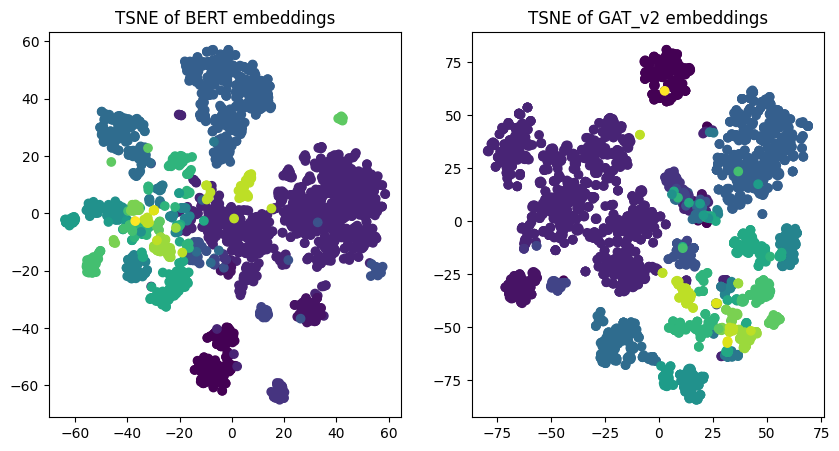

In [69]:
model.eval()
embeddings_model = model(g, nfeat).detach().mean(dim=[1]).numpy()[1:2637]
get_embs_and_plot(embeddings_model, g, nfeat, model_name, sections)

In [70]:
bert_scores, linear_regression_score_bert, svm_score_bert, model_scores, linear_regression_score_model, svm_score_model = eval_model(model_name)
joblib.dump(value=bert_scores, filename=f"../results/scores/scores_bert.pickle")
joblib.dump(value=model_scores, filename=f"../results/scores/scores_{model_name}.pickle")
print(f'Модель: {np.mean(model_scores):.2f}±{np.std(model_scores):.2f}')
print(f'Берт: {np.mean(bert_scores):.2f}±{np.std(bert_scores):.2f}')
print(f'SVR BERT: {svm_score_bert:.2f}')
print(f'SVR модель: {svm_score_model:.2f}')
print(f'Линейная регрессия BERT: {linear_regression_score_bert:.2f}')
print(f'Линейная регрессия модель {linear_regression_score_model:.2f}')

Модель: -0.21±0.49
Берт: -0.23±0.76
SVR BERT: -0.78
SVR модель: -0.44
Линейная регрессия BERT: 0.10
Линейная регрессия модель 0.12


In [71]:
embeddings_model = np.load(file=f"../results/embs/{model_name}.npy")
embeddings_model_2d = np.load(file=f"../results/embs/{model_name}_2d.npy")

dim = embeddings_model.shape[1]
index = faiss.IndexFlatL2(dim)
index.add(embeddings_model)

In [72]:
topn = 7
with open('results.txt', 'w', encoding='utf8') as fp:
    order = list(range(len(okved_data)))
    shuffle(order)
    for idx in tqdm(order):
        # print(idx)
        D, I = index.search(embeddings_model[[idx]], topn)
        data = okved_data['native_code'] + ' ' + okved_data['name_okved']
        closest = data.iloc[I[0]].tolist()
        closest_s = '\n'.join(closest)
        fp.write(f"{idx}\n{closest_s}\n\n")

100%|██████████| 2636/2636 [00:01<00:00, 1512.13it/s]


In [73]:
names = (okved_data['native_code'] + ': ' + okved_data['name_okved']).apply(cut, ln=50)
colors = okved_data['section_id'].values

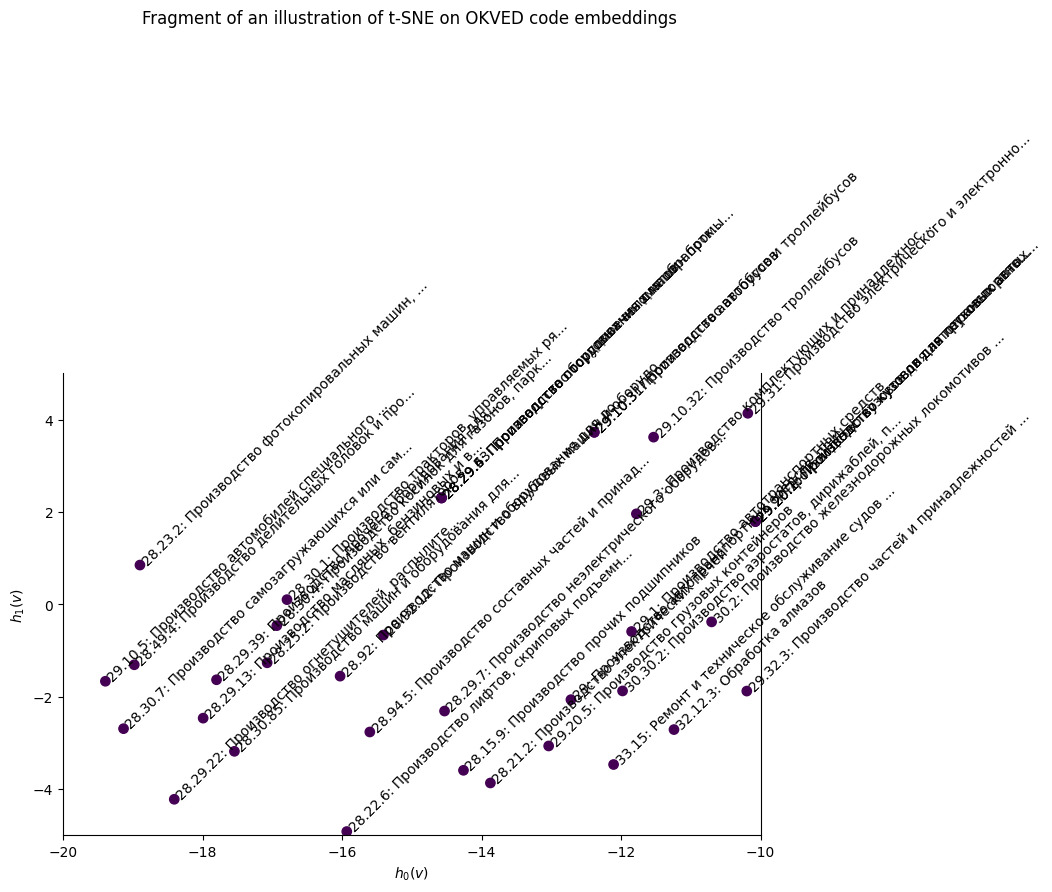

In [74]:
okved_data[okved_data['native_code']=='46.72.21'].index[0]-1
names = (okved_data['native_code'] + ': ' + okved_data['name_okved']).apply(cut, ln=50)
colors = okved_data['section_id'].values
draw_2d(embeddings_model_2d, names, colors, 
        xlim=(-20, -10), ylim=(-5, 5), 
        figsize=(9, 6), annotate=True,
        node_size=45,
        hide_spins=('top', ))